# Scientific Document Classification

Programming Language: Python 3.7.6 Jupyter Notebook

Libraries used:
* Fastai 1.0.61
* pytorch-transformers
* transformers - version 3.4.0
* tensorflow - version 2.3.0
* gc
* datetime
* urllib3 - version 1.25.10
* gensim

## Table of Contents

1. [Introduction](#sec_1)
2. [Installation and Transformers](#sec_2)
3. [Parameters Setting](#sec_3)
4. [Customise LongformerTokenizer](#sec_4)
5. [Data Preparation](#sec_5)
6. [Customise Longformer Model](#sec_6)
7. [Prediction](#sec_7)
8. [Conclusion](#sec_8)
9. [References](#sec_9)

# 1. Introduction <a class="anchor" id="sec_1"></a>

The dataset for the problem contained abstracts taken from arXiv which is an open access repository for pre-printed English language research publications. The problem at hand is to build a classifier that can most accurately classify a paper into one of the 100 possible categories using the text from the abstract. The training dataset contains labelled abstracts from 29,368 publications. Therefore, the problem can be considered as a supervised learning problem. This report details the efforts taken by the team in identifying suitable models to build the classifier, evaluation of the said models and the final model selected.

After a series of experiments, the Longformer (Transformer) produces the highest accuracy rate at 60.458% (30% of the testing dataset) The coressponding codes from pre-processing steps, model development, and evaluation are shown in this notebook. The following tasks will be carried.

* **Pre-processing**: Training and test data are parsed and read into pandas dataframe. The relevant pre-processing procedures such as removing unmeaningful tags, case normalization, tokenization and stopwords removal are performed with NLP libraries. 

* **Model development**: Longoformer model was built based on keras and having tensorflow as a back-end. The pretrained model is longformer-large. 

* **Model evaluation**: To immediately evaluate model accuracy, a saved model can be loaded from pkl to make prediction. The accuracy score is then computed with fastai metrics

###NOTE: Please do not run all cells at once. Details is provided in SECTION 6 and SECTION 7.

# 2. Libraries Installation and Transformers
## 2.1 Installation

In [ ]:
!pip install transformers==3.4.0
!pip install pytorch-transformers
!pip install tensorflow==2.3.0
!pip install urllib3==1.25.10

In [ ]:
from google.colab import drive #link to google drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch #torch is used in fastai backend
from transformers import LongformerModel, LongformerTokenizer #Longformer model and tokenizer
from fastai.text import * #fastai for creating databung
from fastai.metrics import * #metrics to calculate accuracy
import torch.nn as nn #create a custom model for sequence classification task
# Garbage Collector
import gc 
from datetime import date
# gensim to remove stopwords
from gensim.parsing.preprocessing import STOPWORDS 
# regex
import re
# to display image
from IPython.display import Image

## 2. Transformers and Longformer

The success of Transformers is partly due to the self-attention. Since Transformers was presented, self-attention, which is a special attention mechanism, has been widely successful. Self attention allows model to look at each token in relation to other token within the same sequence. 

Longformer has an attention mechanism that grows linearly along with the sequence length, which is suitable for long documents. The new method applied in longformer is a sliding window of size $w$ for each token to "pay attention" to a portion of all other tokens - those from local attention that bring the most value. The second modification is the dilated sliding widow, which means that $w$ is separated by many empty spaces. These modifications help longformer perform better in long documents. The Scholar Document dataset has abstracts with lengths longer than the maximum length RoBERTA can handle (Maximum length is 384 in RoBERTa while maximum length of abstracts is 491). The illustration of attention of Longformer below is adopted from Longformer: The Long-Document Transformer.  

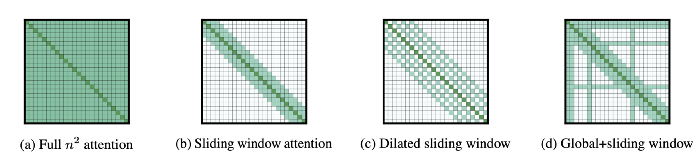

In [ ]:
Image('/content/drive/My Drive/group9_ass2_impl/longformerattention.png', width=700)

Longformer has SOTA performance and consistently outperformed RoBERTa in sequence classification, which is the reason why it was chosen for experimentation with this dataset. The Longformer model is still in development mode from the Huggingface library. 

# 3. Parameters Setting

In [ ]:
# Config class stores value of hyperparameters and folder destinations for training
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)

    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

'''
file_path: path of files eg."FIT5149/"
date: today inform of YYYYMMDD
seed: random seed value
max_lr: maximum learning rate
epochs: number of epochs
bs: batch size, eg: 4, 8, 16 (best is 4 with longformer, >16 cause CUDA error)
max_seq_len: the longest possible length, 491 for this dataset
num_labels: number of categories of documents, 100 for this datasets
hidden_dropout_prob: dropout percentage of neural networks (0.05, 0.10)
hidden_size: 1024 for longformer-large and 768 for longformer-base
valida_pct: validation percentage
start_tok: token defining the beginning of a sentence
end_tok: token defining the ending of a sentence
model_path: the folder destination
pred_path: destination for prediction
train_file_path: destination to trainning dataset
test_file_path: destination to testing dataset
text_column_name: name of the feature columns, e.g: 'abstract'
target_column_name: name of the label columns, e.g: 'label'
'''
config = Config(
    # change to your own path
    file_path = "/content/drive/My Drive/group9_ass2_impl", 
    date = date.today().strftime('%Y%m%d'),
    seed=2020,  
    longformer_model_name='allenai/longformer-large-4096',
    max_lr=1e-5,
    epochs=3, #2 hour for one epoch
    bs=4, # larger than 16 can cause CUDA or OOM problems
    max_seq_len=491, # the max length of abstract is 491
    num_labels=100, # number of labels is 100
    hidden_dropout_prob=.05, #best configuration is 0.05
    hidden_size=1024, # if base model is use, hidden_size should 768
    valid_pct=0.20, #20 percent of dataset used for validation
    start_tok="<s>",
    end_tok="</s>",
    text_column_name= 'abstract',
    target_column_name= 'label'
) 
# define link to model
config.model_path = f'Epoch_{config.epochs}_len_{config.max_seq_len}_{config.date}.pkl'
# define link to prediction
config.pred_path = f'{config.longformer_model_name}_Epoch_{config.epochs}_len_{config.max_seq_len}_{config.date}.csv'
# define link to training dataset
config.train_file_path=f'{config.file_path}/train_data_labels.csv'
# define link to testing dataset
config.test_file_path=f'{config.file_path}/test_data.csv' 

# 4. Customize LongformerTokenizer 

In this section we will utilize BaseTokenizer from FastAi with some modifications for LongformerTokenizer to work

In [ ]:
class FastAiLongformerTokenizer(BaseTokenizer):
    """Wrapper around longformerTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: LongformerTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer # tokenizer is LongformerTokenizer
        self.max_seq_len = max_seq_len #the longest length of a sentence, e.g 491
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds longformer bos and eos tokens and limits the maximum sequence length""" 
        # starting of the sequence is <s> and ending is </s>
        return [config.start_tok] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [config.end_tok]

# create fastai tokenizer for longformer
longformer_tok = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
# we will adopt tokenizer (BaseTokenizer) from fastai
fastai_tokenizer = Tokenizer(tok_func=FastAiLongformerTokenizer(longformer_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

In [ ]:
# create fastai vocabulary for Longformer Model
path = Path()
longformer_tok.save_vocabulary(path)
# load vocab to dictionary
with open('vocab.json', 'r') as f:
    longformer_vocab_dict = json.load(f)
# fastai longformer vocabulary is built on list of vocab dictionary    
fastai_longformer_vocab = Vocab(list(longformer_vocab_dict.keys()))

# Setting up pre-processors
class LongformerTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class LongformerNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_longformer_vocab, **kwargs)


def get_longformer_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Longformer. The start of sentence token (sos)
    and the end of sentence token will be removed because these two were set at
    the beggining of the notebook. A custom vocabulary is used to match with the
    orginal longformer model. 
    """
    return [LongformerTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

# 5. Data Preparation

In [ ]:
# Creating a longformer specific DataBunch class. In side Databunch contains 
# training and validation data. We adopted this approach from Fastai1v to quickly 
# train data with learner. The class longformerDatabunch is inherited from Text
# DataBunch. 
class LongformerDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training longformer"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

class LongformerTextList(TextList):
    _bunch = LongformerDataBunch
    _label_cls = TextList

We will drop duplicated abstract that has many different labels because these data points will affect the learning of model negatively. We only keep the datapoint with only one label for training purpose.

In [ ]:
# load train dataset
train_df = pd.read_csv(config.train_file_path)
# drop duplicated abstract, 
train_df = train_df.drop_duplicates(subset=['abstract'], keep=False)
# load test dataset
test_df = pd.read_csv(config.test_file_path)
#setting feature and label columns
feat_cols = config.text_column_name
label_cols = config.target_column_name

After dropping 9892 duplicated datapoints, we will augmented training data by the same kind of data from Kaggle website [8]. However, we only get the data that has the labels similar to the labels in the training set. The data processing is done with this dataset so that only 'abstract' and 'labels' columns are kept. The processed dataset is in csv file from_arxiv.csv.

In [ ]:
# Create a checklist for training labels to makesure that only labels in training
# dataset presented
check_list = list(train_df['label'].unique())
# load data from additional arxiv
data_added = pd.read_csv(f'{config.file_path}/from_arxiv.csv')
# drop duplicated data
data_added = data_added.drop_duplicates(subset=['abstract'], keep=False)
# filter only labels that contained in checklist or training data labels
data_added = data_added[data_added['label'].isin(check_list)]
# setting train_id for data_added 
data_added['train_id'] = data_added.index
# concatenate data_added to train_df for training
train_df = pd.concat([data_added[:4000],train_df])

## Preprocessing Data

In this step, we will remove stopwords and all the special characters except coma and period for attention mechanism.

In [ ]:
def pre_processing(df):
    
    # split into single token
    df['tokens'] = df['abstract'].apply(lambda x : x.split(' '))
    
    # remove stopwords
    df['tokens'] = df['tokens'].apply(lambda x : [i for i in x if (i not in STOPWORDS)])
    
    # merge back into text
    df['abstract'] = df['tokens'].apply(lambda x: ' '.join(x))

    # removing special characters, except coma and period. 
    df['abstract'] = df['abstract'].apply(lambda x: re.sub(r"[^a-zA-Z0-9\.\,]+", ' ', x))
    
    return(df)
# process training data
train_df = pre_processing(train_df)
# process testing data
test_df = pre_processing(test_df)

In this step we create databunch. The below code will take around a few minutes to finish.

In [ ]:
# loading the tokenizer and vocab processors
processor = get_longformer_processor(
    tokenizer=fastai_tokenizer, vocab=fastai_longformer_vocab)

'''
Creating databunch
from_df: get training data
split_by_rand_pct: randomly splitting training data into train and validation data
label_from_df: labels from training set
add_test: process test dataset
databunch: pulling batches (with batch_size preset to train)
'''
data = LongformerTextList.from_df(train_df, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(valid_pct=config.valid_pct, seed=config.seed) \
    .label_from_df(cols=label_cols, label_cls=CategoryList) \
    .add_test(LongformerTextList.from_df(test_df, ".", cols=feat_cols, processor=processor)) \
    .databunch(bs=config.bs, pad_first=False, pad_idx=0)

# remove unnecessary dataframe, the train_df, test_df, and data_added are no longer
# needed. 
del train_df  
del test_df 
del data_added
gc.collect()  # clean the memory

0

# 6. Customise Longformer Model

We customise longformer model below. The size of longformer-large-4096 model is around 1.75 Gb, which will take around few minutes to load.

In [ ]:
# defining Longformer architecture
class CustomLongformerModel(nn.Module):
    def __init__(self, num_labels=config.num_labels):
        super(CustomLongformerModel, self).__init__()
        self.num_labels = num_labels  # get number of labels
        self.longformer = LongformerModel.from_pretrained('allenai/longformer-large-4096', return_dict=True)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        outputs = self.longformer(input_ids, token_type_ids, attention_mask)
        pooled_output = outputs.pooler_output
        # get logits value for classifier
        logits = self.classifier(pooled_output) 
        return logits
# set the model
longformer_model = CustomLongformerModel()
# define learning with model and metrics
learn = Learner(data, longformer_model, metrics=[accuracy]) #  use acc as evaluation metrics
# to_fp16() to lower the bandwith, leaving some more memory to boost training
# time. 
learn = learn.to_fp16()  

Below is the code for loading pretrained model. Please be aware that if the below cell is run, the next three cell should not be run, otherwise the whole process will be trained again. 

In [ ]:
# This is to load pretrained pickle model file, comment and replace the path (if neccessary)
# to go to correct model file. Please be aware this cell is run,
# GO STRAIGHT to section 7 for prediction WITHOUT running the next THREE cells. 
# Otherwise the model will take around 9 hours to train from the beginning. 
learn = load_learner(config.file_path,'best_model.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.normalization.LayerNorm' has changed. you can retrieve the original source code by accessing the object's source att

In [ ]:
# DO NOT RUN THIS CELL IF MODEL IS LOADED FROM DRIVE
# Clean memory before training
gc.collect() 
# signal model to set training mode because model was working in inference mode
# by default
learn.model.longformer.train() 
# first epoch is enough before finding learning rate
learn.fit_one_cycle(1, max_lr=config.max_lr) 
# uncomment below to store model, otherwise this can be done after training finish

epoch,train_loss,valid_loss,accuracy,time
0,1.305303,1.400678,0.641086,1:28:49


In [ ]:
# DO NOT RUN THIS CELL IF MODEL IS LOADED FROM DRIVE
# best learning rate found is 1e-5 after training. Detailed in the report
learn.fit_one_cycle(config.epochs, max_lr=config.max_lr) # train on one epoch

epoch,train_loss,valid_loss,accuracy,time
0,1.265698,1.375096,0.639448,1:28:52
1,0.923056,1.191162,0.690922,1:28:55
2,0.668595,1.150556,0.702621,1:28:54


# 7. Prediction

Do not run the cell below if model is loaded from drive. Please run the next cell to predict results

In [ ]:
# DO NOT RUN THIS CELL IF MODEL IS LOADED FROM DRIVE
# export model, name now best_model_rerun do separate from
# previous run.
learn.export(f'{config.file_path}/best_model_rerun.pkl') 

Predicting time will take from 20 minutes to 30 minutes. 

In [ ]:
# read test data again
sub = pd.read_csv(config.test_file_path)
# make prediction
for index, loc in sub.iterrows():
    sub.at[index,'label'] = learn.predict(sub.at[index,'abstract'])[0]
# dropping column abstract
sub = sub.drop(columns=['abstract'])
# set index 
sub = sub.set_index(['test_id'])
# produce csv file for submission
sub.to_csv(f'{config.file_path}/pred_labels.csv')

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx_min = (t != self.pad_idx).nonzero().min()


# 8. Conclusion

Longformer has a much better performance in comparsion with other classical machine learning models tested with this dataset. Cleaning stopwords, special characters, duplicated data, and augmented data from arxiv website did help improve performance of the models. Beside, rigorously tuning hyper parameters is not less important, which helps the performance of longformer to reach to the top of the Kaggle Challenge. The drawbacks of this model is the requirement of GPU and long training time. At least 8.5 hours is needed as running time for this notebook. Running time limitation on Colab is also a factor that prevents us from trialling new ideas and tuning experiments. Overall, this is a very challenging dataset that provides extremely helpful experience in terms of data processing, features selection, model selection, and hyperparameters tuning. 

# 9. References

[1] Longformer: The Long-Document Transformer https://arxiv.org/abs/2004.05150 

[2] RoBERTa: A Robustly Optimized BERT Pretraining Approach https://arxiv.org/abs/1907.11692

[3] https://huggingface.co/transformers/model_doc/longformer.html

[4] https://huggingface.co/transformers/model_doc/roberta.html

[5] https://fastai1.fast.ai/

[6] https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html

[7] gensim https://pypi.org/project/gensim/

[8] Link to additional arxiv data from Kaggle https://www.kaggle.com/Cornell-University/arxiv

[9] Attention is all you need https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

[10] Illustrated Transformershttp://jalammar.github.io/illustrated-transformer/